# Exploring unsupervised learning with my Spotify playlist

If you haven't already, check out my blog post on medium: https://medium.com/@dionb

Section 1 are all the helper functions used in the main function.

If you want to analyze your own Spotify playlist, skip to section 2.1.

## Section 1: Helper Functions

These are all the external functions that are referenced in the main function *analyze_my_spotify()*

In [1]:
import requests
import urllib.parse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Data representation of a song:

In [2]:
class Song:
    
    def __init__(self, name, artists, track_id, features, cluster="NONE"):
        """name is a string
        
           artists is a list of artists 
           
           track_id is the unique track_id of a song 
           
           features is a dictionary with attributes:
           
                 - danceability, energy, loudness, speechiness,
                 - acousticness, instrumentalness, liveness,
                 - valence, tempo, and time signature
                
            cluster is a string denoting playlist after clustering (default="NONE")
        """
        self.name=name
        self.artists=artists
        self.track_id=track_id
        self.features=features
        self.cluster=cluster
        
    def __repr__(self):
        song_rep = f"{self.name} by {self.artists}"
        
        return song_rep

In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Integrating Python with Spotify Web API. Idea of defining a SpotifyClient referenced from another Spotify related project from: https://github.com/imdadahad/automate-spotify-python/blob/master/spotify_client.py

In [4]:
class SpotifyClient(object):
    
    ### NOTE: integrating Spotify Web API by using a SpotifyClient object
    ### and the logic behind get_requests was obtained from the link above :)
    ### all else is my code

    def __init__(self, api_token):
        self.api_token = api_token
    
    def get_playlist(self, lop):
        
        def get_requests(url):
            request = requests.get(
                    url,
                    headers={
                        "Content-Type": "application/json",
                        "Authorization": f"Bearer {self.api_token}"
                    }
                ).json()
            
            return request
        
        
        
        master_lst=[ ] # list of all tracks across lop
        
        ## Extract the tracks from each playlist
        print("Extracting Tracks from Playlists")
        print('\n')
        
        for playlist in lop:
            query = urllib.parse.quote(playlist)
            url = f"https://api.spotify.com/v1/playlists/{query}/tracks"
            playlist_results=get_requests(url)
            
            # get the unique track ids from the playlist
            track_ids=list(set(map(lambda x: x['track']['id'],playlist_results['items'])))
            
            
            # save the track_ids for all songs in lop
            master_lst=master_lst+track_ids
            
        print(f'{len(master_lst)} songs detected. Extracting Track Info')
        
        ## Now extract features for each track_id in list of track_ids
        ## However there is a request limit=100 for song attributes
        ## so loop over len(master_lst) times (song and artists are seperate requests)
        
        feature_set = {"danceability", "energy", "loudness","speechiness",
                       "acousticness", "instrumentalness","liveness", 
                       "valence", "tempo"} #"time_signature"}
        
        ## extract the song info
        tracks = {}
        
        print('\n')
        
        for bops in master_lst:
            url = f"https://api.spotify.com/v1/audio-features?ids={bops}"
            song_attributes = get_requests(url)['audio_features'][0]
            
            
            url = f"https://api.spotify.com/v1/tracks?ids={bops}"
            info = get_requests(url)['tracks'][0] #info on song name and artists
            artists = list(map(lambda x: x['name'], info['artists']))
            
            
            tracks[bops] = Song(info['name'],artists, bops, 
                                {feature: song_attributes[feature] for feature in  feature_set})
        
        #return tracks
        #results={'master_lst': master_lst, 'tracks': tracks}
        return tracks

**normalize_matrix**

Normalizes columns of matrix, D.

**dict_to_matrix**

Convert dictionary of tracks as a matrix representation.

In [5]:
def normalize_matrix(D):
    n = D.shape[0]
    p = D.shape[1]
    
    for col in list(range(0,p)):
        col_mean = np.mean(D[:,col])
        col_var= np.var(D[:,col])
        D[:,col] = (D[:,col]-col_mean)/(col_var**0.5)
    
    return D
    

def dict_to_matrix(d, normalize=True):
    """Takes a dictionary d as input and creates an n x p matrix
       where n is the sample size and p is the number of covariates
       
       Takes a boolean value if we wish to normalize the design matrix; default is TRUE
       since this is the input to Principal Component Analysis (PCA) and clustering
       
    """
    
    covariates = ["danceability", "energy", "loudness",
                  "speechiness","acousticness", "instrumentalness",
                  "liveness", "valence", "tempo"]#, "time_signature"]
    
    
    matrix_flat = np.array([]) # a flattened matrix (aka array) to which to populate
    for bops in d.values():
        bop = bops.features
        row = np.array([bop["danceability"], bop["energy"], bop["loudness"],
                        bop["speechiness"], bop["acousticness"],
                        bop["instrumentalness"], bop["liveness"],
                        bop["valence"], bop["tempo"]])#, bop["time_signature"]])
        
        matrix_flat=np.append(matrix_flat, row)
    
    ## convert flat matrix to matrix (design matrix)
    n = len(d)
    p = len(covariates)
    matrix_dim = matrix_flat.reshape(n,p)
    
    if normalize:
        matrix_dim = normalize_matrix(matrix_dim)
        #for col in list(range(0,p)):
        #    col_mean = np.mean(matrix_dim[:,col])
        #    col_var= np.var(matrix_dim[:,col])
        #    matrix_dim[:,col] = (matrix_dim[:,col]-col_mean)/(col_var**0.5)
            
    return matrix_dim

**myPCA**

my implementation of PCA

In [6]:
def myPCA(X):
    """Principal Component Analysis take as input
       the centered design matrix, X
    """
    
    ### Output the correlation matrix ## 
    
    print(color.BOLD+"Correlation Matrix"+color.END)
    print('\n')
    
    df = pd.DataFrame(X)
    df.columns = ["danceability", "energy", "loudness",
                  "speechiness","acousticness", "instrumentalness",
                  "liveness", "valence", "tempo"]#, "time_signature"]
    
    plt.figure(figsize=(20,10))
    matrix = np.triu(df.corr())
    ax=sns.heatmap(df.corr(), annot=True, mask=matrix)
    plt.show()
    
    
    
    # variance-covariance structure for sample
    # X'X where X centered scale by n-1
    
    
    Sigma = np.matmul(np.transpose(X), X)
    Sigma_scaled = Sigma/((len(X)-1))
    
    #########################################
    
    ####### SVD of X #######    
    
    #########################################
    
    ####### diagonalize Sigma = VDV' #######
    
    eigenpairs=np.linalg.eig(Sigma_scaled)
    eigenvals = eigenpairs[0]
    eigenvecs = eigenpairs[1]
    
    sorted_eVals = sorted(eigenvals, reverse=True) # lambda_(max),...,lambda_(min)
    order = [sorted_eVals.index(i) for i in eigenvals]
    diag = np.diag(eigenvals)
    eigenvecs = eigenvecs[:, order] # eigen vectors sorted per vals
    
    ########
    
    #u = [(1/(x**0.5)) for x in sorted_eVals]
    
    #U=np.array([])
    #for i in list(range(0,len(u))):
    #    u_i = u[i]*np.matmul(X,eigenvecs[:,i])
    #    U = np.append(U, u_i)
    
    #U=np.transpose(U.reshape(len(u), len(X))) # no need to extend basis since n<<p
    
    #########################################
    
    expl_var = sorted_eVals/sum(sorted_eVals) # explained variance
    
    print('\n')
    
    prop_lst = [ ]
    print(color.BOLD+"Cumulative Explained Variance and Corresponding Eigenvalues:"+color.END)
    for i in list(range(0, len(expl_var))):
        prop = round(sum(expl_var[:i+1])/sum(expl_var),3)
        print(f"k={str(i+1)}: [exp_var={str(prop)}, lambda={str(round(sorted_eVals[i],3))}]")
        prop_lst = prop_lst+[prop]
    
    print('\n')
    plt.figure(figsize=(20,10))
    plt.axhline(y=0.9, color='red', linewidth=0.8,linestyle='--')
    plt.plot(list(range(1,len(expl_var)+1)),prop_lst, linewidth=2 , marker='8')
    plt.title("Proportion of Explained Variation (Cumulative)", fontsize=20)
    plt.xlabel('Number of Principal Components Included', fontsize=16)
    plt.ylabel('Proportion Explained', fontsize=16)
    plt.show()
    
    print('\n')
    print("Based on the diagnostic plots, indicate a new dimension for your data.")
    k = int(input("Dimensionality Reduction parameter: "))
    
    
    ########
    
    # Reduced data: X = U_k(S_k)V_k' by SVD
    
    #######
    
    X_new = np.matmul(X,eigenvecs)
    
    ## Standardize X_new
    
    X_new=normalize_matrix(X_new)
    
    
    
    # non truncated results
    results = {'X_new': X_new,  
               'Eigenmat': eigenvecs,
               'Eigenvecs':sorted_eVals,
               'k':k}
    
    return results
    



**get_KNN**

My implementation of K-Nearest Neighbour

In [8]:
def get_KNN(df, k, song_name):
    track_lst = dict(zip([x.name.upper() for x in df.index], list(range(0,len(df)))))
    df['row']=list(range(0, len(df)))
    x = df[df['row']==track_lst[song_name.upper()]]
    
    n = len(df)
    p = len(list(df.columns))-1
    
    norms_matrix = np.empty((n,p))
    for i in list(filter(lambda x: x!='row', list(df.columns))):
        norms_matrix[:,i] = (np.array(df[i]) - float(x[i]))**2 # center around song
    
    
    norms_matrix = norms_matrix.reshape(len(df), len(list(df.columns))-1)
    norms_vec = norms_matrix.sum(axis=1)**0.5 # get the euclidean dist
    track_lst = dict(zip(np.array([x for x in df.index]), norms_vec))
    
    # sort dictionary per value (i.e, songs per euclidean distance)
    track_dict = {key: round(val,2) for key, val in sorted(list(track_lst.items()), key=lambda distance: distance[1])}
    return list(track_dict.items())[1:k+1]

**Cluster object and instance methods**

Binary tree-like representation of a cluster - filled with instance methods to: get euclidean distance, compute centroid, get weights, convert Cluster object into adjacency matrix, and get clusters.

In [9]:
class Cluster:
    """a Cluster has the following properties:
         - a centroid (a list of length n representing n-dimensional space)
         - songs is a set that contains all the track ids of a cluster
         - a left child (a Cluster object or False)
         - a right child (a Cluster object or False)
         - weight (distance between left and right child)
         
        a cluster of size 1 has left=right=weight=False by default;
        
        note the left and right child of a cluster is itself a cluster
    """
    
    def __init__(self, centroid, songs = {},left=False, right=False, weight=False):
        self.centroid = centroid
        self.songs = songs
        self.left = left
        self.right = right
        self.weight = weight
        
    
        
    def __repr__(self):
        centr = f"Centroid at {self.centroid}"
        child = f"Left Child {self.left}"
        child2 = f"Right Child {self.right}"
        rep =  centr + '\n' + child + '\n' + child2
        return rep
        
    def __eq__(self, other):
        return self.left==other.left and self.right==other.right
    
    def get_euclidean(self, other):
        sum_sq = sum(list(map(lambda diff: (diff)**2, (map(lambda x,y: x-y, self.centroid, other.centroid)))))
        return round(np.sqrt(sum_sq), 4)
            
        
    def compute_centroid(self):
        """compute the cluster's centroid given a tree structure, self"""
        
        # get to the root of the tree (aka the individual songs) and get song's centroid
        queue = [self]
        centroids = []
        
        while queue != []:
            curr = queue.pop(0)
            
            # base case: if both child are False, then get the centroid
            if not (curr.left and curr.right):
                centroids.append(curr.centroid)
            
            else:
                queue.append(curr.left)
                queue.append(curr.right)
            
         
        # the centroids is a list of lists 
        # want to sum the i-th element across all n-lists in list
        
        dim = len(centroids[0]) # determine cluster dimension in R^n
        cluster_centroid = list(map(lambda y: np.mean(y), [[x[i] for x in centroids] for i in list(range(0,dim))]))
        
        results = {'centroid': cluster_centroid, 'children': len(centroids)}
        return results
    
    
    
    def get_weight(self):
        queue = [self]
        wt = []
        
        while queue!=[]:
            curr = queue.pop(0)
            
            if not (curr.left and curr.right):
                pass
            
            elif not curr.left:
                queue.append(curr.right)
                wt.append(curr.weight)
                
            elif not curr.right:
                queue.append(curr.left)
                wt.append(curr.weight)
                
            else:
                queue.append(curr.right)
                queue.append(curr.left)
                wt.append(curr.weight)
        
        return sorted(wt, reverse=True)
    
    
    def get_sse(self):
        """takes a cluster as input and computes the 
           sum squared variation between the cluster
           centroid and all the members
        """
        
        # get to the root of the tree (aka the individual songs) and get song's centroid
        queue = [self]
        centroids = [] # of members
        
        while queue != []:
            curr = queue.pop(0)
            
            # base case: if both child are False, then get the centroid
            if not (curr.left and curr.right):
                #centroids.append(curr.centroid)
                dist = curr.get_euclidean(self)**2
                centroids.append(dist)
            else:
                queue.append(curr.left)
                queue.append(curr.right)
                
                
        #dim = len(centroids[0]) # determine cluster dimension in R^n
        master_centroid = self.centroid
        #sse = #sum(list(map(lambda x: x**2,centroids)))
        
        #sum(list(map(lambda x: sum((x.get_euclidean(self))**2), centroids)))
        
        return np.sqrt(sum(centroids))
    
    
    def count_children(self):
        queue = [self]
        centroids = [] # of members
        
        while queue != []:
            curr = queue.pop(0)
            
            # base case: if both child are False, then get the centroid
            if not (curr.left and curr.right):
                #centroids.append(curr.centroid)
                dist = curr.get_euclidean(self)**2
                centroids.append(dist)
            else:
                queue.append(curr.left)
                queue.append(curr.right)
                
    def cluster_to_adjacency(self):
        edges ={}
        queue = [self]
        
        while queue!=[]:
            curr = queue.pop(0)
            key = "-".join(sorted([x for x in curr.songs]))
            edges[key]={}
            
            if type(curr.left)!=type(True): #self has a left child
                child = curr.left
                child_name = "-".join(sorted([x for x in child.songs]))
                edges[key][child_name]=curr.weight
                queue.append(child)
            
            if type(curr.left)!=type(True): #self has a right child
                child = curr.right
                child_name = "-".join(sorted([x for x in child.songs]))
                edges[key][child_name]=curr.weight
                queue.append(child)
            
        return edges
    
    def get_clusters(self, wt, k):
        queue = [self]
        clusters = []
        
        while len(clusters)<k:
            curr=queue.pop(0)
            #print(queue, len(clusters))
            
            if curr.weight == wt:
                clusters.append(curr)
            
            elif curr.weight>wt:
                if curr.left.weight < wt:
                    clusters.append(curr.left)
                else:
                    queue.append(curr.left)
                
                if curr.right.weight < wt:
                    clusters.append(curr.right)
                
                else:
                    queue.append(curr.right)
                
                #:
                #    queue.append(curr.left)
                #    queue.append(curr.right)
                    
            else:
                queue.append(curr.left)
                queue.append(curr.right)
        
        return clusters
            

**cluster_by_centroids**

Hierarchical clustering using centroid linkage--not used in blog post since didn't get good results

In [10]:
## A CENTROID IMPLEMENTATION ##

def cluster_by_centroids(tracks_mat):
    
    # define a local function that gets the nearest
    # cluster (neighbour) between self and the cluster_queue
    #def get_NN(x, cluster_queue):
    #    cluster_dist = [np.sqrt(sum((y-x)**2)) for y in cluster_queue]
    #    closest_nbr = sorted(cluster_dist)
    #    return cluster_dist.index(closest_nbr[0])
    
    # define the roots of the tree:
    cluster_queue = [Cluster(x, False, False, False) for x in tracks_mat]
    
    
    # nested clustering loop
    while len(cluster_queue)>1:
        
        #curr = cluster_queue.pop(0)
        current_min = 100**100 # an arbitrarily large number
        #current_max = -current_min
        cluster_1 = None 
        cluster_2 = None
        n = len(cluster_queue)
        
        # find the closest pairwise cluster
        for i in list(range(0, n)):
            curr = cluster_queue[i]
            for j in list(range(i+1,n)):
                other = cluster_queue[j]
                euclidean = curr.get_euclidean(other)
                
                if euclidean < current_min:
                    current_min = euclidean
                    cluster_1 = curr
                    cluster_2 = other
                    i_star = i
                    j_star = j-1
                
                #if euclidean > current_max:
                #    current_max = euclidean
        
        # remove the clusters to be merged from queue
        cluster_queue.pop(i_star)
        cluster_queue.pop(j_star)
        
        
        # merge two closest cluster
        merged = Cluster(0, # centroid = 0 is a placeholder to be updated
                        cluster_1, 
                        cluster_2,
                        current_min, current_max)
        
        merged.centroid = merged.compute_centroid()
        
        # add the merged cluster into the queue
        cluster_queue.append(merged)
    
    # return the parent node (from which the entire tree can be deduced)
    return merged

**cluster_by_variability**

Hierarchical clustering using ward's linkage

In [11]:
## MINIMIZE PAIRWISE CLUSTER VARIANCE ##

def cluster_by_variability(tracks_mat, song_labels):
    
    # define a local function that gets the nearest
    # cluster (neighbour) between self and the cluster_queue
    #def get_NN(x, cluster_queue):
    #    cluster_dist = [np.sqrt(sum((y-x)**2)) for y in cluster_queue]
    #    closest_nbr = sorted(cluster_dist)
    #    return cluster_dist.index(closest_nbr[0])
    
    # define the roots of the tree:
    cluster_queue = [Cluster(tracks_mat[i], {song_labels[i].track_id}, False, False, False)
                     for i in list(range(len(song_labels)))]
    
    
    #return cluster_queue
    # nested clustering loop
    while len(cluster_queue)>1:
        
        #curr = cluster_queue.pop(0)
        current_min = 100**100 # an arbitrarily large number
        cluster_1 = None 
        cluster_2 = None
        n = len(cluster_queue)
        
        # find the closest pairwise cluster
        for i in list(range(0, n)):
            curr = cluster_queue[i]
            n_i = curr.compute_centroid()['children']
            
            for j in list(range(i+1,n)):
                other = cluster_queue[j]
                
                
                n_j = other.compute_centroid()['children']
                delta_ij = round(((n_i*n_j)/(n_i+n_j))*sum(((np.array(curr.centroid)-np.array(other.centroid))**2)),4)
                
                # save the info about the two clusters to be merged
                if delta_ij < current_min:
                    current_min = delta_ij
                    cluster_1 = curr
                    cluster_2 = other
                    i_star = i
                    j_star = j-1
        
        # remove the clusters to be merged from queue
        
        #print(current_min, cluster_1.songs, cluster_2.songs)
        cluster_queue.pop(i_star)
        cluster_queue.pop(j_star)
        
        
        # merge two closest clusters
        merged = Cluster(0, # centroid = 0 is a placeholder to be updated
                        cluster_1.songs.union(cluster_2.songs),
                        cluster_1, 
                        cluster_2,
                        current_min)
        
        merged.centroid = merged.compute_centroid()['centroid']
        
        # add the merged cluster into the queue
        cluster_queue.append(merged)
    
    # return the parent node (from which the entire tree can be deduced)
    return merged


## Section 2: Run Function

In [12]:
def analyze_my_spotify():
    # user credential input
    print(color.BOLD+'Hello.'+color.END)
    
    print('\n')
    print('Please obtain a request token from https://spoti.fi/31fCKVz using your Spotify credentials. ')
    
    token = input("Enter your token: ")
    
    
    s=SpotifyClient(token)
    
    print('\n')
    
    print('Please enter the spotify playlist ID seperating by commas: ')
    playlist_ids = input("Playlist URIs: ")
    playlist_ids = list(map(lambda x: x.strip(),playlist_ids.split(",")))
    
    tracks = s.get_playlist(playlist_ids)
    #playlist_ids=["2WuJPdcCpLONytcEggSkSC"]#'3L2HToam3LDyxwd3vkWID0',"6GDCfyYIfhTdc6QUwOlZdE"]
    
    print('\n')
    print("Finished Extracting Track Information.")
    
    
    X=dict_to_matrix(tracks)
    
    feature_lst = ["danceability", "energy", "loudness",
                  "speechiness","acousticness", "instrumentalness",
                  "liveness", "valence", "tempo", "time_signature"]
    
    # plot the marginal distribution of variables
    #print('Exploratory Plots: ')
    
    #fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    #axes[0].distplot(X[:,0],hist=False, rug=True, color="firebrick")
    #axes[1].hist(X[:,1])
    #fig.tight_layout()
    
    
    print('\n')
    # start PCA
    print(color.BOLD+color.BLUE+"Principal Component Analysis"+color.END)
    print('\n')
    pca_results = myPCA(X)
    
    # the transformed design matrix, X under a different basis 
    df=pd.DataFrame(pca_results['X_new'], index=tracks.values())
    
    print('\n')
    # Plot the data in 2D and 1D
    
    print('Would you like to plot the data in 2-dimensions (Using the 2 Principal Components)?')
    plot_in2d = input('Y/N: ')
    
    if plot_in2d.upper().strip()=='Y':
        norms=[x for x in np.sqrt((df[0]**2)+(df[1]**2))]
        cols = [norms.index(i) for i in norms if round(i,3)<=1.96] #inside the neigborhood
        cols2 = list(filter(lambda x: x not in cols, list(range(0,len(df)))))
        
        plt.figure(figsize=(20,10))
        plt.scatter(df[0][cols], df[1][cols], marker='o', linewidth=5, alpha=0.8, label="delta=1.96 nbrhood of (0,0)")
        plt.scatter(df[0][cols2],df[1][cols2],marker='*', linewidth=5,alpha=0.8, color="firebrick")
        
        for x in cols2: 
            plt.annotate(x, (df[0][x], df[1][x]), fontsize=17)
        
        plt.xlabel("First Principal Component", fontsize=15)
        plt.ylabel("Second Principal Component", fontsize=15)
        plt.legend(loc=2, fontsize=14)
        plt.title(f"Variability Explained = {round(sum(pca_results['Eigenvecs'][0:2])/sum(pca_results['Eigenvecs']),3)}", fontsize=18)
        print('\n')
        print(color.UNDERLINE+'2-Dimensional Representation of the Playlist:' + color.END)
        plt.show()
        
        not_nhbr=pd.DataFrame([], index=cols2,columns = ["Song", "PC1","PC2"])

        track_names = list(tracks.values())
        for x in cols2:
            not_nhbr.at[x,'Song']=track_names[x]
            not_nhbr.at[x,'PC1']=df[0][x]
            not_nhbr.at[x,'PC2']=df[1][x]

        print(not_nhbr)
        print('\n')
                  
    print('\n')
            
    # Find the nearest neighbors of the average
    print(color.BOLD+ color.BLUE +'K-Nearest Neighbours' +color.END)

    print('Given a song name in the playlist, K-Nearest Neighbours gives K songs that are most similar to the inputted song in the playlist.')
    print('\n')
    print('Would you like to proceed with looking at the KNN of songs in your playlist?')
    print('Y - proceed with KNN; N - proceed directly to clustering.')
    print('\n')
    Knn_bool = input('Y/N: ').upper().strip()
    print('\n')

    if Knn_bool=='Y':
        boole = True
        track_lst = {x.name.upper() for x in df.index}
    else:
        boole = False
                  
    def prompt_knn():
        print('\n')
        print("Please enter the song name as it appears on the spotify playlist.")
        song_name = input("Song name: ").strip()
        if song_name.upper() not in track_lst:
            print(f"{song_name} was not found in the inputted playlist. Please enter a valid song.")
            prompt_knn()
        else:
            print(f"How many neighbours around {song_name}?")
            k = int(input(f"k nearest neighbours around {song_name} with k = ").strip())
            print(pd.DataFrame(get_KNN(df, k, song_name), columns = ['Song', 'Euclidean Distance']).to_string())
                  
                  
    while boole:
        prompt_knn()
        #if s!=None:
        #    print(pd.DataFrame(get_KNN(df, s[1], s[0]), columns = ['Song', 'Euclidean Distance']).to_string())
        print('\n')
        print('Would you like to look at the Nearest Neighbours of more songs?')
        b=input('Y/N: ').upper().strip()
        if b != 'Y':
            boole = False
    
    print('\n')
    #print('Terminating KNN.')
    
    print('\n')
    # Cluster
                  
    print(color.BLUE+color.BOLD+'Agglomerative Hierarchical Clustering' + color.END)
    print('\n')
    print('Clustering Playlist Using Within Cluster Variability as a Dissimilarity Measure')
    clustering=cluster_by_variability(pca_results['X_new'][:,0:pca_results['k']], df.index)
    print('\n')
    print(color.UNDERLINE+'Clustering Results'+color.END)
    wts = clustering.get_weight()
    wts.append(0)
    
    print('\n')
    
    plt.figure(figsize=(20,10))
    plt.plot(list(range(1, len(wts)+1)),wts, marker='o')
    plt.xlabel('Number of Clusters',fontsize=18)
    plt.ylabel('Merging Cost', fontsize =18)
    plt.title('Number of Clusters vs Dissimilarity', fontsize=20)
    plt.show()
                  
    print('\n')
    print(f'Select a number of clusters, k, where k is an integer from 1 to {len(df)}')
    cluster_no = int(input("Number of Clusters: ").strip())
    
    # Extracting playlists
    print('\n')
    print("Extracting Playlists")
    playlist_clusters = clustering.get_clusters(wts[cluster_no-1], cluster_no)
    
                  
    track_df=pd.DataFrame(tracks.items(),columns=['track_id', 'name'])
    #track_df['track_id']=track_df['track_id'].astype('str')
    track_df['artists']=track_df['name'].apply(lambda x: '-'.join(x.artists))
    track_df['name']=track_df['name'].apply(lambda x: x.name)

    print('\n')
            
    i=1
    for playlists in playlist_clusters:
        print(color.BOLD+ f'Playlist {i}' +color.END)
        playlst = pd.DataFrame(playlists.songs, columns=['track_id'])
        playlst[f'Cluster_{i}'] = int(i)
        songs = [tracks[x] for x in playlists.songs]
                  
        for x in songs:
            print(x)
                  
        print('\n')
        track_df = pd.merge(track_df,playlst, on='track_id',how='left')
        print('\n')
        print('\n')
        i=i+1
                  
    track_df.fillna(0, inplace=True)
    track_df['Cluster']=track_df.sum(axis=1)
    track_df = track_df[['track_id', 'name','artists','Cluster']]
    
    #return track_df

## Section 2.1: Analyze your own spotify.

Re-run the cell below and follow the prompts. I left a sample output:

Notes:

- To get your spotify credentials go to: https://spoti.fi/31fCKVz, click get token, check playlist-read-private, and click request token (Note that credentials expire every 1 hour)

- Each playlist should only have 100 songs since that is the limit (so if you have a playlist of over 100 + songs, need to seperate them manually into 100-song playlists).

- The playlist ID is the last 22 strings of the spotify url. https://open.spotify.com/playlist/3L2HToam3LDyxwd3vkWID0 => 3L2HToam3LDyxwd3vkWID0 

- Any further questions or comments? Reach out to my LinkedIn @ https://www.linkedin.com/in/dion-banno-78b955192/

Thank you ! :)

Hello.


Please obtain a request token from https://spoti.fi/31fCKVz using your Spotify credentials. 
Enter your token: BQAl-wqbe8YRbdzShAHM81w5yVt4ecTRjoevFlJiakCM0zz5lSGNM2BHxkM4oyhleu0dgC5GnQ6fGSDuCE6hBtLCFEn9G823udOZf1BEUB3qsuwl64EYefaz5w6x40qEyfvrs4WTCBRF3_jX2PNe_Nc-4rkpiUkZi6Ak0LTUkX_jtxrAnJ5fQ-pSwBooNAsk2CjTVy9wg87boow6xyD7wA


Please enter the spotify playlist ID seperating by commas: 
Playlist URIs: 3L2HToam3LDyxwd3vkWID0,6GDCfyYIfhTdc6QUwOlZdE
Extracting Tracks from Playlists


192 songs detected. Extracting Track Info




Finished Extracting Track Information.


Principal Component Analysis


Correlation Matrix




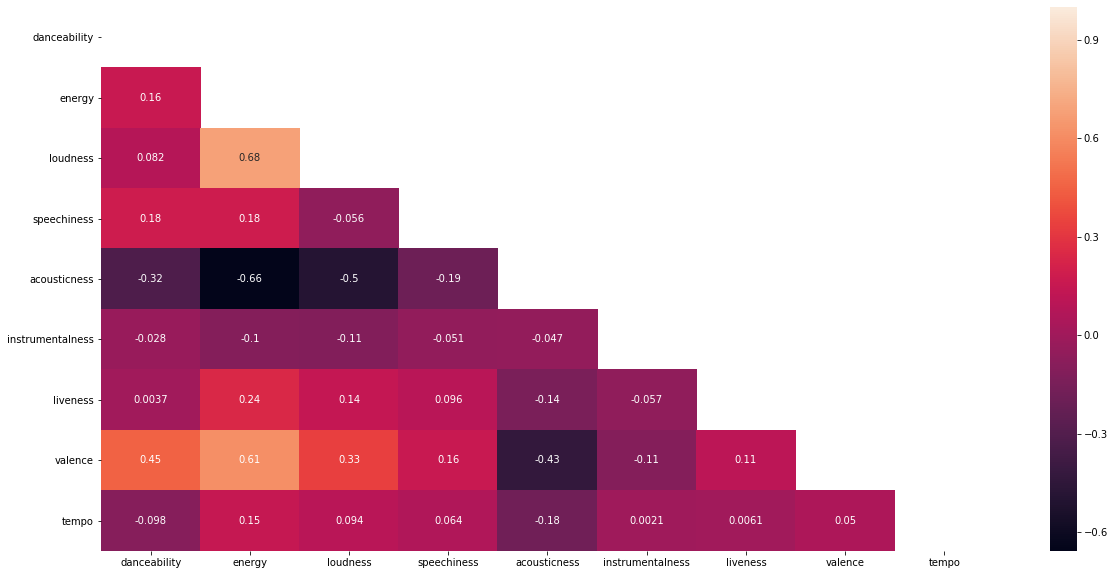



Cumulative Explained Variance and Corresponding Eigenvalues:
k=1: [exp_var=0.323, lambda=2.921]
k=2: [exp_var=0.46, lambda=1.245]
k=3: [exp_var=0.578, lambda=1.066]
k=4: [exp_var=0.694, lambda=1.048]
k=5: [exp_var=0.8, lambda=0.958]
k=6: [exp_var=0.88, lambda=0.728]
k=7: [exp_var=0.938, lambda=0.524]
k=8: [exp_var=0.981, lambda=0.386]
k=9: [exp_var=1.0, lambda=0.173]




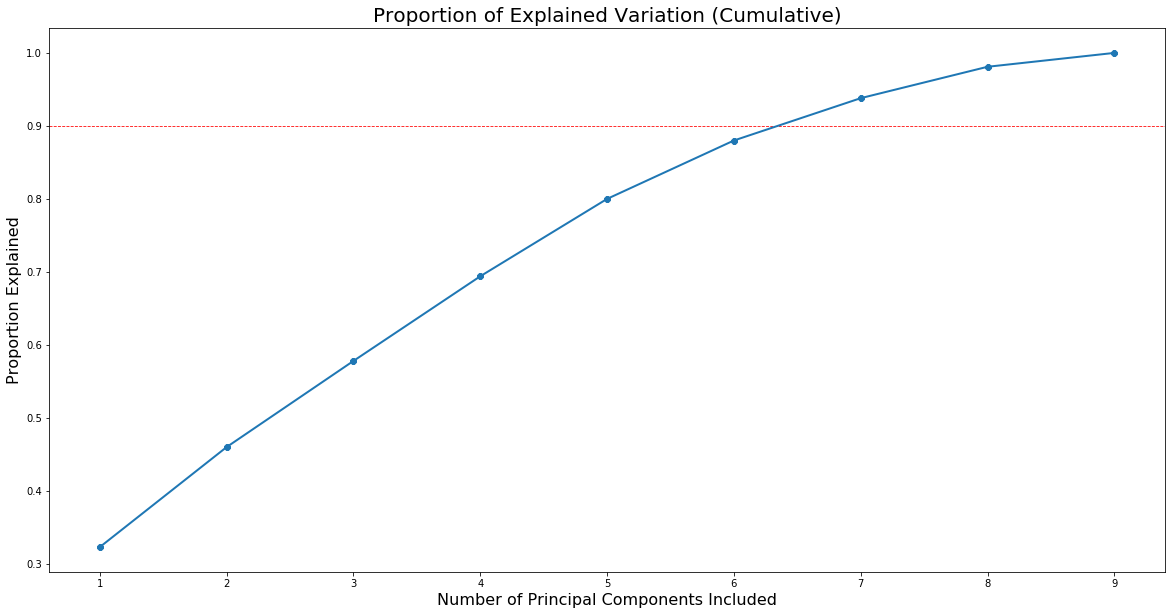



Based on the diagnostic plots, indicate a new dimension for your data.
Dimensionality Reduction parameter: 7


Would you like to plot the data in 2-dimensions (Using the 2 Principal Components)?
Y/N: y


2-Dimensional Representation of the Playlist:


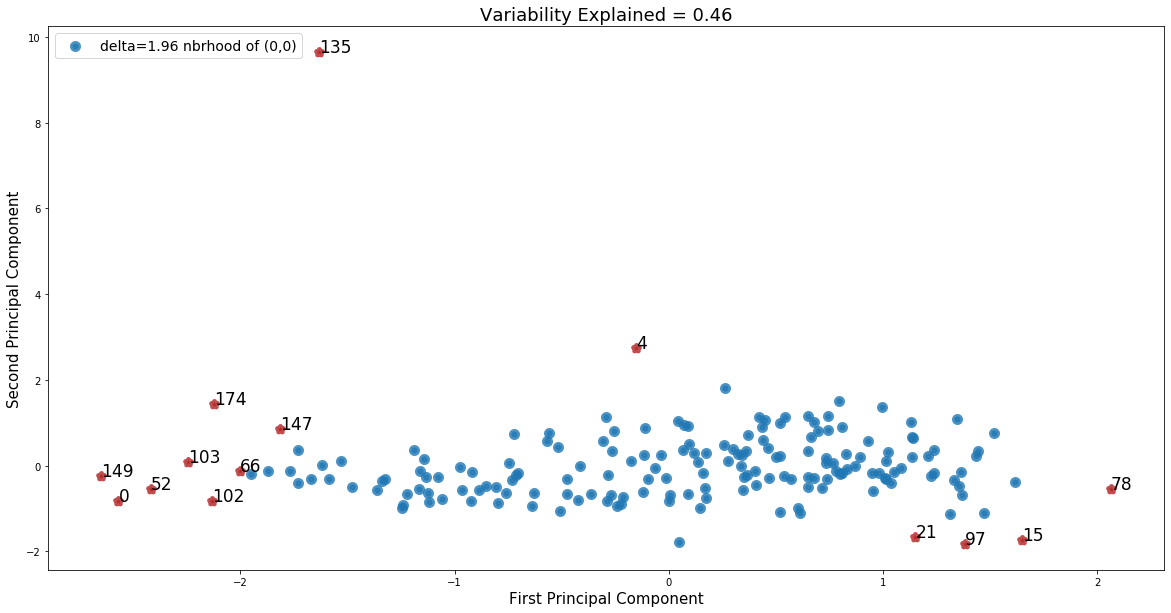

                                                  Song       PC1        PC2
0                          Lead The Way by ['Alextbh']  -2.56948   -0.83609
4                I Want You Around by ['Snoh Aalegra'] -0.151517    2.74437
15   Make It Happen - Live at Madison Square Garden...   1.65065   -1.72953
21   If We by ['Mariah Carey', 'Nate Dogg', 'Ja Rule']   1.15119   -1.66848
52                          Honesty by ['Pink Sweat$']  -2.41948  -0.538872
66                             Jealous by ['Labrinth']  -2.00015  -0.125578
78                                  Juice by ['Lizzo']   2.06409  -0.551501
97   Good as Hell (feat. Ariana Grande) by ['Lizzo'...   1.38044   -1.83821
102                 Make You Feel My Love by ['Adele']  -2.13105  -0.822189
103                       Jolene by ['Ray LaMontagne']  -2.24303  0.0884444
135                         Think About Me by ['dvsn']  -1.63308    9.65013
147              Warm (feat. Mia) by ["Dre'es", 'Mia']  -1.81626   0.843313
149  you wer

In [ ]:
analyze_my_spotify()